# 特征选择：对坏属性说不
讨论特征时经常遇到噪声问题。通常，我们手上的特征有可能预测性不高，有时甚至会阻碍模型的预测性能。我们使用过标准化和正则化等方法来减轻其危害，但是总有一天需要解决这种问题。

本章会讨论特征工程的一个子集，称为特征选择。特征选择是从原始数据中选择对于预测流
水线而言最好的特征的过程。更正式地说，给定n 个特征，我们搜索其中包括k（k < n）个特征的子集来改善机器学习流水线的性能。

In [ ]:
# 导入网格搜索模块
from sklearn.model_selection import GridSearchCV
def get_best_model_and_accuracy(model, params, X, y):
  grid = GridSearchCV(model, # 要搜索的模型
                      params, # 要尝试的参数
                      error_score=0.) # 如果报错，结果是0
  grid.fit(X, y) # 拟合模型和参数

  # 经典的性能指标
  print("Best Accuracy: {}".format(grid.best_score_))

  # 得到最佳准确率的最佳参数
  print("Best Parameters: {}".format(grid.best_params_))

  # 拟合的平均时间（秒）
  print("Average Time to Fit (s):{}".format(round(grid.cv_results_['mean_fit_time'].mean(), 3)))
  
  # 预测的平均时间（秒）
  # 从该指标可以看出模型在真实世界的性能
  print("Average Time to Score (s):{}".format(round(grid.cv_results_['mean_score_time'].mean(), 3)))

这个函数的总体目标是给出一个基线数据，因为我们会用这个函数评估每个特征选择方法，带来一种标准化的感觉。虽然本质上和之前的工作没什么区别，但是这次把工作形式化成函数，而且用另外的指标为机器学习流水线和特征选择模块打分，而不是只看准确率。

## 案例分析：信用卡逾期数据集
特征选择算法可以智能地从数据中提取最重要的信号并忽略噪声，达到以下两个结果。
* 提升模型性能：在删除冗余数据后，基于噪声和不相关数据做出错误决策的情况会减少，
而且模型可以在重要的特征上练习，提高预测性能。
* 减少训练和预测时间：因为拟合的数据更少，所以模型一般在拟合和训练上有速度提升，
让流水线的整体速度更快。

In [ ]:
import pandas as pd
import numpy as np

# we will set a random seed to ensure that whenever we use random numbers 
# which is a good amount, we will achieve the same random numbers
np.random.seed(123)

In [ ]:
# https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients
credit_card_default = pd.read_csv('credit_card_default.csv')

In [ ]:
credit_card_default.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [ ]:
credit_card_default.shape  # 30,000 rows and 24 columns

(30000, 24)

In [ ]:
# Some descriptive statistics
credit_card_default.describe().T

,count,mean,std,min,25%,50%,75%,max
LIMIT_BAL,30000.0,167484.322667,129747.661567,10000.0,50000.00,140000.0,240000.00,1000000.0
SEX,30000.0,1.603733,0.489129,1.0,1.00,2.0,2.00,2.0
EDUCATION,30000.0,1.853133,0.790349,0.0,1.00,2.0,2.00,6.0
MARRIAGE,30000.0,1.551867,0.521970,0.0,1.00,2.0,2.00,3.0
AGE,30000.0,35.485500,9.217904,21.0,28.00,34.0,41.00,79.0
PAY_0,30000.0,-0.016700,1.123802,-2.0,-1.00,0.0,0.00,8.0
PAY_2,30000.0,-0.133767,1.197186,-2.0,-1.00,0.0,0.00,8.0
PAY_3,30000.0,-0.166200,1.196868,-2.0,-1.00,0.0,0.00,8.0
PAY_4,30000.0,-0.220667,1.169139,-2.0,-1.00,0.0,0.00,8.0
PAY_5,30000.0,-0.266200,1.133187,-2.0,-1.00,0.0,0.00,8.0


default payment next month（下个月逾期）是响应，其他都是特征，或者说是潜在的
预测变量。很明显，特征的尺度迥异，这会是我们选择数据处理方法和模型时需要考虑的因素。

在前面的章节中，我们使用StandardScalar 和归一化解决了这些问题，而本章会**忽略这些问题，以便集中处理更相关的问题。**

In [ ]:
# check for missing values, none in this dataset
credit_card_default.isnull().sum()

LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64

太好了，没有缺失值。我们在之后的案例分析中会再次处理缺失值，但是现在有更重要的事
情要做。

接下来为机器学习流水线设置变量，代码如下：

In [ ]:
# Create our feature matrix
X = credit_card_default.drop('default payment next month', axis=1)

# create our response variable
y = credit_card_default['default payment next month']

In [ ]:
# get our null accuracy rate
# 因为要执行分类任务，所以取一个空准确率，确保机器学习的性能比基准更好。
y.value_counts(normalize=True)

0    0.7788
1    0.2212
Name: default payment next month, dtype: float64

本例需要击败77.88%这个准确率，也就是没有逾期者的比例（0 代表没有逾期）。

In [ ]:
from sklearn.model_selection import GridSearchCV


def get_best_model_and_accuracy(model, params, X, y):
    grid = GridSearchCV(model,           # the model to grid search
                        params,          # the parameter set to try 
                        error_score=0.)  # if a parameter set raises an error, continue and set the performance as a big, fat 0
    grid.fit(X, y)           # fit the model and parameters
    # our classical metric for performance
    print "Best Accuracy: {}".format(grid.best_score_)
    # the best parameters that caused the best accuracy
    print "Best Parameters: {}".format(grid.best_params_)
    # the average time it took a model to fit to the data (in seconds)
    print "Average Time to Fit (s): {}".format(round(grid.cv_results_['mean_fit_time'].mean(), 3))
    # the average time it took a model to predict out of sample data (in seconds)
    # this metric gives us insight into how this model will perform in real-time analysis
    print "Average Time to Score (s): {}".format(round(grid.cv_results_['mean_score_time'].mean(), 3))

In [ ]:
# Import four machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


# Set up some parameters for our grid search
# We will start with four different machine learning models
# logistic regression, KNN, Decision Tree, and Random Forest
lr_params = {'C':[1e-1, 1e0, 1e1, 1e2], 'penalty':['l1', 'l2']}
knn_params = {'n_neighbors': [1, 3, 5, 7]}
tree_params = {'max_depth': [None, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]}
forest_params = {'n_estimators': [10, 50, 100], 'max_depth': [None, 1, 3, 5, 7]}


# instantiate the four machine learning models
lr = LogisticRegression()
knn = KNeighborsClassifier()
d_tree = DecisionTreeClassifier()
forest = RandomForestClassifier()

In [ ]:
get_best_model_and_accuracy(lr, lr_params, X, y)

/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Best Accuracy: 0.809533333333
Best Parameters: {'penalty': 'l1', 'C': 0.1}
Average Time to Fit (s): 0.584
Average Time to Score (s): 0.004


可以看见，逻辑回归只用原始数据就打败了空准确率。它拟合训练集平均需要0.6 s，而只用20 ms 就可以得出结果。这其实是有道理的：要拟合数据，scikit-learn 的逻辑回归需要在内存中创建一个巨大的矩阵，但是预测时只需要相乘并做一点标量计算。

In [ ]:
get_best_model_and_accuracy(knn, knn_params, X, y)

Best Accuracy: 0.760233333333
Best Parameters: {'n_neighbors': 7}
Average Time to Fit (s): 0.027
Average Time to Score (s): 0.91


不出所料，KNN 在拟合时间上表现得更好。因为在拟合时，KNN 只需要按方便检索和及时
处理的方法存储数据。注意，这里的准确率甚至不如空准确率！你有可能在考虑原因是什么。如果你想到“等等，KNN 是按照欧几里得距离进行预测的，在非标准数据上可能会失效，但是其他3 个算法不会受此影响”，那么你是对的。

KNN 是基于距离的模型，使用空间的紧密度衡量，假定所有的特征尺度相同，但是我们知
道数据并不是这样。因此对于KNN，我们需要更复杂的流水线，以更准确地评估基准性能。代码如下：

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# construct pipeline parameters based on the parameters
# for KNN on its own
knn_pipe_params = {'classifier__{}'.format(k): v for k, v in knn_params.iteritems()}
print knn_pipe_params

# KNN requires a standard scalar due to using Euclidean distance as
# the main equation for predicting observations
knn_pipe = Pipeline([('scale', StandardScaler()), ('classifier', knn)])

# quick to fit, very slow to predict
get_best_model_and_accuracy(knn_pipe, knn_pipe_params, X, y)

{'classifier__n_neighbors': [1, 3, 5, 7]}


/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python2.7/dist-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/usr/local/lib/python2.7/dist-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


Best Accuracy: 0.8008
Best Parameters: {'classifier__n_neighbors': 7}
Average Time to Fit (s): 0.041
Average Time to Score (s): 6.647


首先注意，在用StandardScalar 进行z 分数标准化处理后，这个流水线的准确率至少比
空准确率要高，但是这也严重影响了预测时间，因为多了一个预处理步骤。目前，逻辑回归依然领先：准确率更高，速度更快。我们继续讨论两个基于树的模型，从更简单的决策树开始：

In [ ]:
get_best_model_and_accuracy(d_tree, tree_params, X, y)

Best Accuracy: 0.820266666667
Best Parameters: {'max_depth': 3}
Average Time to Fit (s): 0.278
Average Time to Score (s): 0.004


真厉害！现在决策树的准确率是第一，而且拟合和预测的速度也很快。实际上，决策树的拟
合速度比逻辑回归快，预测速度比KNN 快。我们最后测试一下随机森林，代码如下：

In [ ]:
get_best_model_and_accuracy(forest, forest_params, X, y)

Best Accuracy: 0.8189
Best Parameters: {'n_estimators': 100, 'max_depth': 7}
Average Time to Fit (s): 1.234
Average Time to Score (s): 0.049


比逻辑回归和KNN 好得多，但是没有决策树好。我们汇总一下结果，看看应该使用哪个
模型。

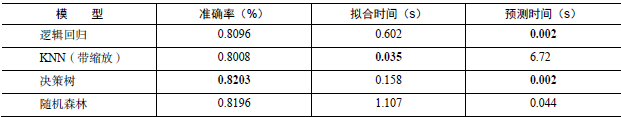

决策树的准确率最高，并且预测时间和逻辑回归并列第一，而带缩放的KNN 拟合最快。总
体而言，决策树应该是最适合下一步采用的模型，因为它在两个最重要的指标上领先：
* 我们想要最高的准确率，以保证预测的准确性；
* 考虑到实时生产环境，预测时间低大有裨益。

我们使用的办法是在选择特征之前选择模型。虽然不必要，但是在时间有限的情
况下这样做一般很省时。你可以尝试多种模型，不必拘泥于一个模型。


既然知道了要使用决策树，那么：
* 要击败的新基线准确率是0.8203，即拟合整个数据集的准确率；
* 不再需要StandardScaler 了，因为决策树不受其影响。

回想一下，选择特征是为了提高预测能力，降低时间成本。所以这里介绍两种类型：
* 基于统计和基于模型的特征选择。基于统计的特征选择很大程度上依赖于机器学习模型之外的统计测试，以便在流水线的训练阶段选择特征。
* 基于模型的特征选择则依赖于一个预处理步骤，需要训练一个辅助的机器学习模型，并利用其预测能力来选择特征。
* 这两种类型都试图从原始特征中选择一个子集，减少数据大小，只留下预测能力最高的特征。我们可以依靠自己的智慧来选择特征，但实际上通过每种方法的例子对相应的流水线性能进行测量也很有效。

### 5.3.1 基于统计的特征选择

#### 1. 使用皮尔逊相关系数
皮尔逊相关系数（是Pandas 默认的）会测量列之间的线性关系。该系数在-1～1 变化，0 代表没有线性关系。相关性接近-1 或1 代表线性关系很强。

值得注意的是，皮尔逊相关系数要求每列是正态分布的（我们没有这样假设）。在很大程度上，我们也可以忽略这个要求，因为数据集很大（超过500 的阈值）①。

In [ ]:
credit_card_default.corr()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
LIMIT_BAL,1.000000,0.024755,-0.219161,-0.108139,0.144713,-0.271214,-0.296382,-0.286123,-0.267460,-0.249411,...,0.293988,0.295562,0.290389,0.195236,0.178408,0.210167,0.203242,0.217202,0.219595,-0.153520
SEX,0.024755,1.000000,0.014232,-0.031389,-0.090874,-0.057643,-0.070771,-0.066096,-0.060173,-0.055064,...,-0.021880,-0.017005,-0.016733,-0.000242,-0.001391,-0.008597,-0.002229,-0.001667,-0.002766,-0.039961
EDUCATION,-0.219161,0.014232,1.000000,-0.143464,0.175061,0.105364,0.121566,0.114025,0.108793,0.097520,...,-0.000451,-0.007567,-0.009099,-0.037456,-0.030038,-0.039943,-0.038218,-0.040358,-0.037200,0.028006
MARRIAGE,-0.108139,-0.031389,-0.143464,1.000000,-0.414170,0.019917,0.024199,0.032688,0.033122,0.035629,...,-0.023344,-0.025393,-0.021207,-0.005979,-0.008093,-0.003541,-0.012659,-0.001205,-0.006641,-0.024339
AGE,0.144713,-0.090874,0.175061,-0.414170,1.000000,-0.039447,-0.050148,-0.053048,-0.049722,-0.053826,...,0.051353,0.049345,0.047613,0.026147,0.021785,0.029247,0.021379,0.022850,0.019478,0.013890
PAY_0,-0.271214,-0.057643,0.105364,0.019917,-0.039447,1.000000,0.672164,0.574245,0.538841,0.509426,...,0.179125,0.180635,0.176980,-0.079269,-0.070101,-0.070561,-0.064005,-0.058190,-0.058673,0.324794
PAY_2,-0.296382,-0.070771,0.121566,0.024199,-0.050148,0.672164,1.000000,0.766552,0.662067,0.622780,...,0.222237,0.221348,0.219403,-0.080701,-0.058990,-0.055901,-0.046858,-0.037093,-0.036500,0.263551
PAY_3,-0.286123,-0.066096,0.114025,0.032688,-0.053048,0.574245,0.766552,1.000000,0.777359,0.686775,...,0.227202,0.225145,0.222327,0.001295,-0.066793,-0.053311,-0.046067,-0.035863,-0.035861,0.235253
PAY_4,-0.267460,-0.060173,0.108793,0.033122,-0.049722,0.538841,0.662067,0.777359,1.000000,0.819835,...,0.245917,0.242902,0.239154,-0.009362,-0.001944,-0.069235,-0.043461,-0.033590,-0.026565,0.216614
PAY_5,-0.249411,-0.055064,0.097520,0.035629,-0.053826,0.509426,0.622780,0.686775,0.819835,1.000000,...,0.271915,0.269783,0.262509,-0.006089,-0.003191,0.009062,-0.058299,-0.033337,-0.023027,0.204149


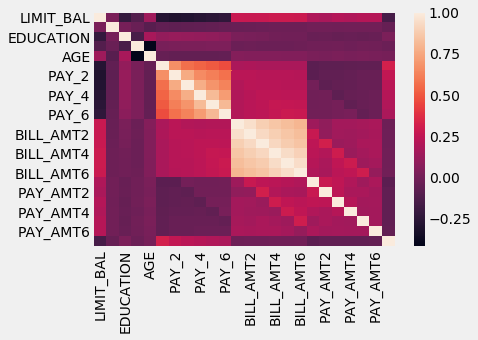

In [ ]:
# 用Seaborn 生成热图
import seaborn as sns
import matplotlib.style as style
# 选用一个干净的主题
style.use('fivethirtyeight')

sns.heatmap(credit_card_default.corr())

注意，heatmap 函数会自动选择最相关的特征进行展示。不过，我们目前关注特征和响应
变量的相关性。我们假设，和响应变量越相关，特征就越有用。不太相关的特征应该没有什么用。

In [ ]:
# 只有特征和响应的相关性
credit_card_default.corr()['default payment next month']  

LIMIT_BAL                    -0.153520
SEX                          -0.039961
EDUCATION                     0.028006
MARRIAGE                     -0.024339
AGE                           0.013890
PAY_0                         0.324794
PAY_2                         0.263551
PAY_3                         0.235253
PAY_4                         0.216614
PAY_5                         0.204149
PAY_6                         0.186866
BILL_AMT1                    -0.019644
BILL_AMT2                    -0.014193
BILL_AMT3                    -0.014076
BILL_AMT4                    -0.010156
BILL_AMT5                    -0.006760
BILL_AMT6                    -0.005372
PAY_AMT1                     -0.072929
PAY_AMT2                     -0.058579
PAY_AMT3                     -0.056250
PAY_AMT4                     -0.056827
PAY_AMT5                     -0.055124
PAY_AMT6                     -0.053183
default payment next month    1.000000
Name: default payment next month, dtype: float64

最后一行可以忽略，因为这是响应变量和自己的相关性。我们寻找相关系数接近1 或1 的
特征，因为这些特征应该会对预测有用。我们用Pandas 过滤出相关系数超过正负0.2 的特征。

In [ ]:
# 只留下相关系数超过正负0.2 的特征
credit_card_default.corr()['default payment next month'].abs() > .2

LIMIT_BAL                     False
SEX                           False
EDUCATION                     False
MARRIAGE                      False
AGE                           False
PAY_0                          True
PAY_2                          True
PAY_3                          True
PAY_4                          True
PAY_5                          True
PAY_6                         False
BILL_AMT1                     False
BILL_AMT2                     False
BILL_AMT3                     False
BILL_AMT4                     False
BILL_AMT5                     False
BILL_AMT6                     False
PAY_AMT1                      False
PAY_AMT2                      False
PAY_AMT3                      False
PAY_AMT4                      False
PAY_AMT5                      False
PAY_AMT6                      False
default payment next month     True
Name: default payment next month, dtype: bool

In [ ]:
# 存储特征
highly_correlated_features = credit_card_default.columns[credit_card_default.corr()['default payment next month'].abs() > .2]

highly_correlated_features

Index([u'PAY_0', u'PAY_2', u'PAY_3', u'PAY_4', u'PAY_5',
       u'default payment next month'],
      dtype='object')

highly_correlated_features 变量会存储与响应变量高度相关的特征，但是需要删掉响
应列的名称，因为在机器学习流水线中包括这列等于作弊：

In [ ]:
# 删掉响应变量
highly_correlated_features = highly_correlated_features.drop('default payment next month')

highly_correlated_features

Index([u'PAY_0', u'PAY_2', u'PAY_3', u'PAY_4', u'PAY_5'], dtype='object')

In [ ]:
# # 只有5 个高度关联的变量
X_subsetted = X[highly_correlated_features]


# 略差一点，但是拟合快了约20 倍
get_best_model_and_accuracy(d_tree, tree_params, X_subsetted, y)  

Best Accuracy: 0.819666666667
Best Parameters: {'max_depth': 3}
Average Time to Fit (s): 0.011
Average Time to Score (s): 0.002


我们的准确率比要击败的准确率0.8203 略差，但是拟合时间快了大概20 倍。我们的模型只需要5 个特征就可以学习整个数据集，而且速度快得多。

接下来回顾一下scikit-learn 流水线，将相关性选择作为预处理阶段的一部分。我们需要创建一个自定义转换器调用刚才的逻辑，并封装为流水线可以使用的类。

将这个类命名为CustomCorrelationChooser，它会实现一个拟合逻辑和一个转换逻辑。
* 拟合逻辑：从特征矩阵中选择相关性高于阈值的列。
* 转换逻辑：对数据集取子集，只包含重要的列。

In [ ]:
from sklearn.base import TransformerMixin, BaseEstimator

class CustomCorrelationChooser(TransformerMixin, BaseEstimator):
    def __init__(self, response, cols_to_keep=[], threshold=None):
        # 保存响应变量
        self.response = response
        # 保存阈值
        self.threshold = threshold
        # 初始化一个变量，存放要保留的特征名
        self.cols_to_keep = cols_to_keep

    def transform(self, X):
        # 转换会选择合适的列
        return X[self.cols_to_keep]

    def fit(self, X, *_):
        # 创建新的DataFrame，存放特征和响应
        df = pd.concat([X, self.response], axis=1)
        # 保存高于阈值的列的名称
        self.cols_to_keep = df.columns[df.corr()[df.columns[-1]].abs() >  self.threshold]
        # 只保留X 的列，删掉响应变量
        self.cols_to_keep = [c for c in self.cols_to_keep if c in X.columns]
        return self

In [ ]:
# 实例化特征选择器
ccc = CustomCorrelationChooser(threshold=.2, response=y)
ccc.fit(X)
ccc.cols_to_keep

['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5']

In [ ]:
ccc.transform(X).head()

,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5
0,2,2,-1,-1,-2
1,-1,2,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,-1,0,-1,0,0


我们看见，transform 方法删除了其他列，只保留大于0.2 阈值的列。现在在流水线中把一切组装起来：

In [ ]:
from copy import deepcopy

# 使用响应变量初始化特征选择器
ccc = CustomCorrelationChooser(response=y)

# 创建流水线，包括选择器
ccc_pipe = Pipeline([('correlation_select', ccc),
                    ('classifier', d_tree)])

tree_pipe_params = {'classifier__max_depth': [None, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]}

# 复制决策树的参数
ccc_pipe_params = deepcopy(tree_pipe_params)

# 更新决策树的参数选择
ccc_pipe_params.update({'correlation_select__threshold':[0, .1, .2, .3]})

print(ccc_pipe_params)

# 比原来好一点，而且很快
get_best_model_and_accuracy(ccc_pipe, ccc_pipe_params, X, y)

{'correlation_select__threshold': [0, 0.1, 0.2, 0.3], 'classifier__max_depth': [None, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]}
Best Accuracy: 0.8206
Best Parameters: {'correlation_select__threshold': 0.1, 'classifier__max_depth': 5}
Average Time to Fit (s): 0.116
Average Time to Score (s): 0.004


哇！第一次的特征选择就已经打败了目标（虽然只高一点点）。我们的流水线显示，如果把
阈值设为0.1，就足以消除噪声以提高准确性，并缩短拟合时间（之前是0.158 s）。下面看看选择器保留了哪些列：

In [ ]:
# 阈值是0.1
ccc = CustomCorrelationChooser(threshold=0.1, response=y)
ccc.fit(X)

# 保留了什么？
ccc.cols_to_keep

['LIMIT_BAL', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

选择器保留了我们找到的5 列，以及LIMIT_BAL 和PAY_6 列。这就是scikit-learn 中自动化网格搜索的好处，让模型达到最优，解放我们的劳动力。

#### 2. 使用假设检验
假设检验是一种统计学方法，可以对单个特征进行复杂的统计检验。在特征选择中使用假设检验可以像之前的自定义相关选择器一样，尝试从数据集中选择最佳特征，但是这里的检验更依赖于形式化的统计方法，并通过所谓的p 值进行检验。

在特征选择中，假设测试的原则是：“特征与响应变量没有关系”（零假设）为真还是假。我
们需要在每个特征上进行检验，并决定其与响应变量是否有显著关系。在某种程度上说，我们的相关性检测逻辑也是这样运作的

In [ ]:
# 在将其用于数据之前，需要定义新模块SelectKBest 和f_classif，代码如下：

# SelectKBest 在给定目标函数后选择k 个最高分
from sklearn.feature_selection import SelectKBest

# ANOVA 测试
from sklearn.feature_selection import f_classif

# f_classif 可以使用负数，但不是所有类都支持
# chi2（卡方）也很常用，但只支持正数
# 回归分析有自己的假设检验

SelectKBest 基本上就是包装了一定数量的特征，而这些特征是根据某个标准保留的前几
名。在这里，我们使用假设检验的p 值作为排名依据。

* 理解p 值

p 值是介于0 和1 的小数，代表在假设检验下，给定数据偶然出现的概率。简而言之，p 值越低，拒绝零假设的概率越大。在我们的例子中，p 值越低，这个特征与响应变量有关联的概率就越大，我们应该保留这个特征。

需要注意的是，f_classif 函数在每个特征上单独（单变量测试由此得名）执行一次ANOVA测试（一种假设检验类型），并分配一个p 值。SelectKBest 会将特征按p 值排列（越小越好），只保留我们指定的k 个最佳特征。

In [ ]:
# 首先实例化一个SelectKBest 模块。我们手动设定k 是5，代表只希望保留5 个最佳的特征：
# 只保留最佳的5 个特征
k_best = SelectKBest(f_classif, k=5)

In [ ]:
# 然后可以像之前使用自定义选择器那样，拟合并转化X 矩阵，选择需要的特征：
# 选择最佳特征后的矩阵
k_best.fit_transform(X, y)

array([[ 2,  2, -1, -1, -2],
       [-1,  2,  0,  0,  0],
       [ 0,  0,  0,  0,  0],
       ...,
       [ 4,  3,  2, -1,  0],
       [ 1, -1,  0,  0,  0],
       [ 0,  0,  0,  0,  0]])

In [ ]:
# 如果想直接查看p 值并检查选择了哪些特征，可以深入观察k_best 变量：

# 取列的p 值
k_best.pvalues_

# 特征和p 值组成DataFrame
# 按p 值排列
p_values = pd.DataFrame({'column': X.columns, 'p_value':
k_best.pvalues_}).sort_values('p_value')

# 前5 个特征
p_values.head()

,column,p_value
5,PAY_0,0.000000e+00
6,PAY_2,0.000000e+00
7,PAY_3,0.000000e+00
8,PAY_4,1.899297e-315
9,PAY_5,1.126608e-279


请注意：p 值不是越小越好，且不能互相比较。

p 值的一个常见阈值是0.05，意思是可以认为p 值小于0.05 的特征是显著的。对于我们的测试，这些列是极其重要的。我们可以用Pandas 的过滤方法，查看所有p值小于0.05 的特征：

In [ ]:
# features with a low p value
p_values[p_values['p_value'] < .05]

,column,p_value
5,PAY_0,0.000000e+00
6,PAY_2,0.000000e+00
7,PAY_3,0.000000e+00
8,PAY_4,1.899297e-315
9,PAY_5,1.126608e-279
10,PAY_6,7.296740e-234
0,LIMIT_BAL,1.302244e-157
17,PAY_AMT1,1.146488e-36
18,PAY_AMT2,3.166657e-24
20,PAY_AMT4,6.830942e-23


In [ ]:
# 大部分特征的p 值都很低，但并不是全部。用下面的代码看看哪些列的p_value 较高：
# 高p 值的特征
p_values[p_values['p_value'] >= .05]

,column,p_value
14,BILL_AMT4,0.078556
15,BILL_AMT5,0.241634
16,BILL_AMT6,0.352123


有3 个特征的p 值较高。我们可以在流水线中应用SelectKBest，看看是否效果更好

In [ ]:
k_best = SelectKBest(f_classif)

# 用SelectKBest 建立流水线
select_k_pipe = Pipeline([('k_best', k_best), ('classifier', d_tree)])
select_k_best_pipe_params = deepcopy(tree_pipe_params)

# all 没有作用
select_k_best_pipe_params.update({'k_best__k':list(range(1,23)) + ['all']})
print(select_k_best_pipe_params) 

# 与相关特征选择器比较
get_best_model_and_accuracy(select_k_pipe, select_k_best_pipe_params, X, y)

{'k_best__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 'all'], 'classifier__max_depth': [None, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]}
Best Accuracy: 0.8206
Best Parameters: {'k_best__k': 7, 'classifier__max_depth': 5}
Average Time to Fit (s): 0.123
Average Time to Score (s): 0.004


SelectKBest 模块和自定义转换器的准确率差不多，但是快了一点

In [ ]:
# 查看选择了哪些特征：
k_best = SelectKBest(f_classif, k=7)
p_values.head(7)

,column,p_value
5,PAY_0,0.000000e+00
6,PAY_2,0.000000e+00
7,PAY_3,0.000000e+00
8,PAY_4,1.899297e-315
9,PAY_5,1.126608e-279
10,PAY_6,7.296740e-234
0,LIMIT_BAL,1.302244e-157


看起来和之前统计方法的选择相同。我们的统计方法有可能只是按顺序选了这7 个特征。

在开始基于模型的特征选择前，我们可以进行一次快速的完整性检查，以确保路线正确。到
目前为止，为了取得最佳准确率，我们已经用了特征选择的两种统计方法，每次选择的7 个特征都一样。如果选择这7 个特征之外的所有特征呢？是不是流水线的准确率会下降，流水线会劣化？我们来确认一下。下面的代码会进行完整性测试：

In [ ]:
# 完整性测试
# 用最差的特征
the_worst_of_X = X[X.columns.drop(['LIMIT_BAL', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'])]

# 如果选择的特征特别差
# 性能也会受影响
get_best_model_and_accuracy(d_tree, tree_params, the_worst_of_X, y)

Best Accuracy: 0.7839
Best Parameters: {'max_depth': 5}
Average Time to Fit (s): 0.248
Average Time to Score (s): 0.004


因此，如果不选择之前的7 个特征，不仅准确性会变差（几乎和空准确率一样差），而且拟
合时间也会变慢。现在我们可以继续了解下一种特征选择方法了——基于模型的方法。

### 5.3.2 基于模型的特征选择

##### 1. 再议自然语言处理

In [ ]:
import pandas as pd

# 推文数据集
tweets = pd.read_csv('twitter_sentiment.csv', encoding='latin1')

In [ ]:
tweets.head()

,ItemID,Sentiment,SentimentText
0,1,0,is so sad for my APL frie...
1,2,0,I missed the New Moon trail...
2,3,1,omg its already 7:30 :O
3,4,0,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,i think mi bf is cheating on me!!! ...


In [ ]:
# 我们先创建一个特征和一个响应变量。回忆一下，因为我们处理的是文本，所以特征变量是文本列，而不是二维矩阵：
tweets_X, tweets_y = tweets['SentimentText'], tweets['Sentiment']

In [ ]:
# null accuracy
tweets_y.value_counts(normalize=True)

1    0.564632
0    0.435368
Name: Sentiment, dtype: float64

In [ ]:
# 可以建立流水线，并用本章使用过的函数进行评估，代码如下：
from sklearn.feature_extraction.text import CountVectorizer
# 导入朴素贝叶斯，加快处理
from sklearn.naive_bayes import MultinomialNB
featurizer = CountVectorizer()

from sklearn.pipeline import Pipeline
text_pipe = Pipeline([('featurizer', featurizer),
                      ('classify', MultinomialNB())])

text_pipe_params = {'featurizer__ngram_range':[(1, 2)],
                    'featurizer__max_features': [5000, 10000],
                    'featurizer__min_df': [0., .1, .2, .3],
                    'featurizer__max_df': [.7, .8, .9, 1.]}

get_best_model_and_accuracy(text_pipe, text_pipe_params, tweets_X, tweets_y)

/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_validation.py:559: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: After pruning, no terms remain. Try a lower min_df or a higher max_df.

  FitFailedWarning)


Best Accuracy: 0.755753132845
Best Parameters: {'featurizer__min_df': 0.0, 'featurizer__ngram_range': (1, 2), 'featurizer__max_df': 0.7, 'featurizer__max_features': 10000}
Average Time to Fit (s):4.959
Average Time to Score (s):0.717


数据不错（空准确率是0.564），但是上一章使用FeatureUnion 模块来组合TfidfVectorizer和CountVectorizer，比这次的分数还高。

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
# import a naive bayes to help predict and fit a bit faster 
from sklearn.naive_bayes import MultinomialNB
featurizer = CountVectorizer()

text_pipe = Pipeline([('featurizer', featurizer), 
                 ('classify', MultinomialNB())])

text_pipe_params = {'featurizer__ngram_range':[(1, 2)], 
               'featurizer__max_features': [5000, 10000],
               'featurizer__min_df': [0., .1, .2, .3],   
               'featurizer__max_df': [.7, .8, .9, 1.]}


get_best_model_and_accuracy(text_pipe, text_pipe_params, 
                            tweets_X, tweets_y)

Best Accuracy: 0.755753132845
Best Parameters: {'featurizer__min_df': 0.0, 'featurizer__ngram_range': (1, 2), 'featurizer__max_df': 0.7, 'featurizer__max_features': 10000}
Average Time to Fit (s): 5.808
Average Time to Score (s): 0.957


看起来SelectKBest 对于文本数据效果不好。如果没有FeatureUnion，我们不能达到上
一章的准确率。值得注意的是，无论使用何种方式，拟合和预测的时间都很长：这是因为统计单变量方法在大量特征（例如从文本向量化中获取的特征）上表现不佳。

In [ ]:
# 更基础，但是用了SelectKBest 的流水线

featurizer = CountVectorizer(ngram_range=(1, 2))

select_k_text_pipe = Pipeline([('featurizer', featurizer), 
                      ('select_k', SelectKBest()),
                      ('classify', MultinomialNB())])

select_k_text_pipe_params = {'select_k__k': [1000, 5000]}

get_best_model_and_accuracy(select_k_text_pipe, 
                            select_k_text_pipe_params, 
                            tweets_X, tweets_y)

Best Accuracy: 0.755703127344
Best Parameters: {'select_k__k': 10000}
Average Time to Fit (s): 6.927
Average Time to Score (s): 1.448


看起来SelectKBest 对于文本数据效果不好。如果没有FeatureUnion，我们不能达到上
一章的准确率。值得注意的是，无论使用何种方式，拟合和预测的时间都很长：这是因为统计单变量方法在大量特征（例如从文本向量化中获取的特征）上表现不佳。

##### 2. 使用机器学习选择特征

* 特征选择指标——针对基于树的模型

在拟合决策树时，决策树会从根节点开始，在每个节点处贪婪地选择最优分割，优化节点
纯净度指标。默认情况下，scikit-learn 每步都会优化基尼指数（gini metric）。每次分割时，模型会记录每个分割对整体优化目标的帮助。因此，在树形结构中，这些指标对特征重要性有作用。

In [ ]:
# model based selection

In [ ]:
# 创建新的决策树分类器
tree = DecisionTreeClassifier()
tree.fit(X, y)

In [ ]:
# 注意：还有其他特征
importances = pd.DataFrame({'importance': tree.feature_importances_, 'feature':X.columns}).sort_values('importance', ascending=False)
importances.head()

,feature,importance
5,PAY_0,0.161829
4,AGE,0.074121
11,BILL_AMT1,0.064363
0,LIMIT_BAL,0.058788
19,PAY_AMT3,0.054911


上表显示，拟合中最重要的特征是PAY_0，和上一章统计模型的结果相匹配。更值得注意的
是第2、第3 和第5 个特征，这3 个特征在进行统计测试前没有显示出重要性。这意味着，这种特征选择方法有可能带来一些新的结果。

In [ ]:
# 和SelectKBest 相似，但不是统计测试
from sklearn.feature_selection import SelectFromModel

SelectFromModel 和SelectKBest 相比最大的不同之处在于不使用k（需要保留的特征
数）：SelectFromModel 使用阈值，代表重要性的最低限度。通过这种方式，这种基于模型的选择器可以脱离人工筛选的过程，只保留与流水线所需同等数量的特征。我们实例化这个类：

In [ ]:
# 实例化一个类，按照决策树分类器的内部指标排序重要性，选择特征
select_from_model = SelectFromModel(DecisionTreeClassifier(), threshold=.05)

In [ ]:
# 然后在SelectFromModel 上拟合数据，调用transform 方法，观察数据选择后的子集：
selected_X = select_from_model.fit_transform(X, y)

In [ ]:
selected_X.shape

(30000, 9)

了解了模块的基本原理后，我们可以在流水线中应用选择功能。我们需要击败的准确率是
0.8206，之前的相关性选择器和ANOVA 都得到了这个准确率（因为选择的特征相同）：

In [ ]:
# see what the params look like so we can gridsearch them.
select_from_model.get_params()

{'estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=None,
             splitter='best'),
 'estimator__class_weight': None,
 'estimator__criterion': 'gini',
 'estimator__max_depth': None,
 'estimator__max_features': None,
 'estimator__max_leaf_nodes': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_impurity_split': None,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__presort': False,
 'estimator__random_state': None,
 'estimator__splitter': 'best',
 'norm_order': 1,
 'prefit': False,
 'threshold': 0.05}

In [ ]:
# 为后面加速
tree_pipe_params = {'classifier__max_depth': [1, 3, 5, 7]}

In [ ]:
from sklearn.pipeline import Pipeline

# 创建基于DecisionTreeClassifier 的SelectFromModel
select = SelectFromModel(DecisionTreeClassifier())
select_from_pipe = Pipeline([('select', select),
                              ('classifier', d_tree)])
select_from_pipe_params = deepcopy(tree_pipe_params)
select_from_pipe_params.update({
                              'select__threshold': [.01, .05, .1, .2, .25, .3, .4, .5, .6, "mean", "median", "2.*mean"],
                              'select__estimator__max_depth': [None, 1, 3, 5, 7]
                              })
print(select_from_pipe_params)

get_best_model_and_accuracy(select_from_pipe,
                            select_from_pipe_params,
                            X, y)

没有比原来的更好

In [ ]:
# 设置流水线最佳参数
select_from_pipe.set_params(**{'select__threshold': 0.01, 
                               'select__estimator__max_depth': None, 
                               'classifier__max_depth': 3})


# 拟合数据
select_from_pipe.steps[0][1].fit(X, y)

# 列出选择的列
X.columns[select_from_pipe.steps[0][1].get_support()]

Index([u'LIMIT_BAL', u'SEX', u'EDUCATION', u'MARRIAGE', u'AGE', u'PAY_0',
       u'PAY_2', u'PAY_3', u'PAY_6', u'BILL_AMT1', u'BILL_AMT2', u'BILL_AMT3',
       u'BILL_AMT4', u'BILL_AMT5', u'BILL_AMT6', u'PAY_AMT1', u'PAY_AMT2',
       u'PAY_AMT3', u'PAY_AMT4', u'PAY_AMT5', u'PAY_AMT6'],
      dtype='object')

这棵树选择了除了两个特征外的所有其他特征，但是和什么都不选的树性能没什么区别。

我们可以继续尝试几种基于树的模型，例如RandomForest（随机森林）和ExtraTrees-Classifier（极限随机树）等，但是效果应该比不基于树的方法差。

##### 3. 线性模型和正则化
SelectFromModel 可以处理任何包括feature_importances_或coef_属性的机器学习
模型。基于树的模型会暴露前者，线性模型则会暴露后者。在拟合后，线性回归、逻辑回归、支持向量机（SVM，support vector machine）等线性模型会将一个系数放在特征的斜率（重要性）前面。SelectFromModel 会认为这个系数等同于重要性，并根据拟合时的系数选择特征。

然而，在使用模型之前，我们需要引入正则化的概念，以选择真正有用的特征。

**正则化简介**

在线性模型中，正则化是一种对模型施加额外约束的方法，目的是防止过拟合，并改进数据
泛化能力。正则化通过对需要优化的损失函数添加额外的条件来完成，意味着在拟合时，正则化的线性模型有可能严重减少甚至损坏特征。有两种广泛使用的正则化方法：L1 和L2 正则化

* L1 正则化也称为lasso 正则化，会使用L1 范数（参见上面的公式）将向量条目绝对值的和加以限制，使系数可以完全消失。如果系数降为0，那么这个特征在预测时就没有任何
意义，而且肯定不会被SelectFromModel 选择。

* L2 正则化也称为岭正则化，施加惩罚L2 范数（向量条目的平方和），让系数不会变成0，但是会非常小。

In [ ]:
# 用正则化后的逻辑回归进行选择
logistic_selector = SelectFromModel(LogisticRegression())

# 新流水线，用LogistisRegression 的参数进行排列
regularization_pipe = Pipeline([('select', logistic_selector), 
                                ('classifier', tree)])

regularization_pipe_params = deepcopy(tree_pipe_params)

# L1 和L2 正则化
regularization_pipe_params.update({
              'select__threshold': [.01, .05, .1, "mean", "median", "2.*mean"],
              'select__estimator__penalty': ['l1', 'l2'],
              })

print regularization_pipe_params

# better than original, in fact the best so far, and much faster on the scoring side
get_best_model_and_accuracy(regularization_pipe, 
                            regularization_pipe_params, 
                            X, y) 


{'select__threshold': [0.01, 0.05, 0.1, 'mean', 'median', '2.*mean'], 'classifier__max_depth': [1, 3, 5, 7], 'select__estimator__penalty': ['l1', 'l2']}
Best Accuracy: 0.821166666667
Best Parameters: {'select__threshold': 0.01, 'classifier__max_depth': 5, 'select__estimator__penalty': 'l1'}
Average Time to Fit (s): 0.51
Average Time to Score (s): 0.001


比原来的好，实际上是目前最好的，也快得多

现在的准确率终于超过统计测试选择器了。再次使用SelectFromModel 的get_support()
方法，列出选择的特征：

In [ ]:
# 设置流水线最佳参数
svc_pipe.set_params(**{'select__estimator__loss': 'squared_hinge', 
                       'select__threshold': 0.01, 
                       'select__estimator__penalty': 'l1', 
                       'classifier__max_depth': 5, 
                       'select__estimator__dual': False})

# 拟合数据
svc_pipe.steps[0][1].fit(X, y)

# 列出选择的列
X.columns[svc_pipe.steps[0][1].get_support()]

Index([u'SEX', u'EDUCATION', u'MARRIAGE', u'PAY_0', u'PAY_2', u'PAY_3',
       u'PAY_5'],
      dtype='object')

非常好！基于逻辑回归的选择器选择了大部分的PAY_X 特征，也发现了性别、教育和婚姻
状况可以帮助预测。接下来用SelectFromModel 模块在支持向量机分类器上进行测试。
支持向量机是分类模型，在空间中绘制线性边界，对二分数据进行分类。这些线性边界叫作
支持向量。目前看来，逻辑回归分类器和支持向量分类器（SVC）的最大区别在于，后者会最大优化二分类项目的准确性，而前者对属性的建模更好。像之前决策树和逻辑回归一样，我们用scikit-learn 实现一个线性SVC 模型，代码如下：

In [ ]:
# SVC 是线性模型，用线性支持在欧几里得空间内分割数据
# 只能分割二分数据
from sklearn.svm import LinearSVC

# 用SVC 取参数
svc_selector = SelectFromModel(LinearSVC())
svc_pipe = Pipeline([('select', svc_selector), 
                     ('classifier', tree)])

svc_pipe_params = deepcopy(tree_pipe_params)

svc_pipe_params.update({
              'select__threshold': [.01, .05, .1, "mean", "median", "2.*mean"],
              'select__estimator__penalty': ['l1', 'l2'],
               'select__estimator__loss': ['squared_hinge', 'hinge'],
               'select__estimator__dual': [True, False]
              })

print svc_pipe_params

# better than original, in fact the best so far, and much faster on the scoring side
get_best_model_and_accuracy(svc_pipe, 
                            svc_pipe_params, 
                            X, y) 


{'select__estimator__loss': ['squared_hinge', 'hinge'], 'select__threshold': [0.01, 0.05, 0.1, 'mean', 'median', '2.*mean'], 'select__estimator__penalty': ['l1', 'l2'], 'classifier__max_depth': [1, 3, 5, 7], 'select__estimator__dual': [True, False]}
Best Accuracy: 0.821233333333
Best Parameters: {'select__estimator__loss': 'squared_hinge', 'select__threshold': 0.01, 'select__estimator__penalty': 'l1', 'classifier__max_depth': 5, 'select__estimator__dual': False}
Average Time to Fit (s): 0.989
Average Time to Score (s): 0.001


太棒了！SVC 达到了最高的准确率。可以看见拟合时间受到了影响，但是如果能把最快的预测和最好的准确率结合，那么机器学习流水线就会很出色了：基于SVC，利用正则化为决策树分类器找到最佳特征。下面看看选择器选择了哪些特征来达到目前的最佳准确率：

In [ ]:
# 设置流水线最佳参数
svc_pipe.set_params(**{'select__estimator__loss': 'squared_hinge',
                      'select__threshold': 0.01,
                      'select__estimator__penalty': 'l1',
                      'classifier__max_depth': 5,
                      'select__estimator__dual': False})
# 拟合数据
svc_pipe.steps[0][1].fit(X, y)

# 列出选择的列
X.columns[svc_pipe.steps[0][1].get_support()]

与逻辑回归比，唯一的区别是PAY_4 特征。但是可以看到，移除单个特征不会影响流水线
的性能。

## 5.4 选用正确的特征选择方法
现在你有可能感到本章的信息过多，难以消化。我们演示了几种选择特征的方法，其中一部
分基于统计学，另一部分基于机器学习模型的二次输出。一个很自然的问题是：应该如何选用特征选择方法？理论上说，最理想的状况是，你可以像本章这样多次尝试，但我们知道这样是不可行的。下面是一些经验，可以在判断特征选择方法的优劣时参考。
* 如果特征是分类的，那么从SelectKBest 开始，用卡方或基于树的选择器。
* 如果特征基本是定量的（例如本例），用线性模型和基于相关性的选择器一般效果更好。
* 如果是二元分类问题，考虑使用SelectFromModel 和SVC，因为SVC 会查找优化二元
分类任务的系数。
* 在手动选择前，探索性数据分析会很有益处。不能低估领域知识的重要性。